In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import logging

import scipy.stats
import numpy as np
import pandas as pd

In [2]:
import diffxpy.api as de

# Introduction

Perfect confounding occurs frequently in differential expression assays, often if biological replicates cannot be spread across conditions: This is often the case with animals or patients. Perfect confounding implies that the corresponding design matrix is not full rank and the model underdetermined. This can be circumvented by certain tricks (where replicates are modeled as the interaction of condition and and a replicate index per condition) which essentially regress repplicates to reference replicates. This may be undesirable as the condition coefficients depend on the identity of the reference replicates and accordingly on the ordering of the replicates, which has no experiental meaning and is purely a result of sample labels. Secondly, such tricks may be hard to come up with in hard cases. Here, we show how one can solve both problems by constraining parameterse in the model. 

# Example 1

In this example, we have 4 biological replicates (animals, patients, cell culture replicates etc.) in a treatment experiment: 2 in each condition (treated, untreated). Accordingly, there is perfect confounding at this level. We circumvent this by constraining the biological replicate coefficients. 

## Simulate data:

### Define design matrices for simulation

Here, we built a one-hot encoded design matrix of discrete covariated (biological replicate and treatment) as a numpy array cells x parameters of model. We will later use this design matrix both for the location and scale model

In [3]:
ncells = 2000
dmat_est_loc = np.zeros([ncells, 6])
dmat_est_loc[:,0] = 1
dmat_est_loc[:500,1] = 1 # bio rep 1
dmat_est_loc[500:1000,2] = 1 # bio rep 2
dmat_est_loc[1000:1500,3] = 1 # bio rep 3
dmat_est_loc[1500:2000,4] = 1 # bio rep 4
dmat_est_loc[1000:2000,5] = 1 # condition effect

coefficient_names = ['intercept', 'bio1', 'bio2', 'bio3', 'bio4', 'treatment']
dmat_est_loc = pd.DataFrame(data=dmat_est_loc, columns=coefficient_names)
dmat_est_loc = de.test.design_matrix(dmat=dmat_est_loc)

In [4]:
dmat_est_scale = np.ones([ncells, 1])
dmat_est_scale = pd.DataFrame(data=dmat_est_scale, columns=['intercept'])
dmat_est_scale = de.test.design_matrix(dmat=dmat_est_scale)

In [5]:
print(np.unique(dmat_est_loc.data_vars["design"], axis=0))

[[1. 0. 0. 0. 1. 1.]
 [1. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]]


In [6]:
print(np.unique(dmat_est_scale.data_vars["design"], axis=0))

[[1.]]


### Run simulation

Simulate data using the design matrix defined above.

In [7]:
from batchglm.api.models.glm_nb import Simulator

sim = Simulator(num_observations=2000, num_features=100)
sim.generate_sample_description(num_batches=0, num_conditions=2)
sim.generate_params()
sim.generate_data()

## Prepare model estimation

### Constraints for model

Define equality constraints that constrain groups of parameters of confounding variable to sum to zero. These constraints make the perfectly confounded epxerimental design identifiable. Here, we have two groups of biological replicates, such as individuals, per condition. Each of these groups is forced to sum to zero so that the treatment effect is the difference between the means of the sample values in log space (inverse linker space). These constraints are encoded as strings. Note that the coefficient names have to be the exactly as defined in the design matrix.

In [8]:
constraints_loc = de.utils.data_utils.build_equality_constraints_string(
    dmat=dmat_est_loc,
    constraints=["bio1+bio2=0", "bio3+bio4=0"],
    dims=["design_loc_params", "loc_params"]
)

The scale model only has an intercept and no perfect confounding, accordingly, no constraints are necessary:

In [9]:
constraints_scale = None

## Run model fitting and differential expression test:

Here, we perform a single-coefficient Wald test on the treatment effect, accounting for all confounders by using the above defined constraints:

In [10]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

import diffxpy.api as de

test = de.test.wald(
    data = sim.X,
    dmat_loc = dmat_est_loc.data_vars['design'],
    dmat_scale = dmat_est_scale.data_vars['design'],
    constraints_loc = constraints_loc,
    constraints_scale = constraints_scale,
    coef_to_test=["treatment"],
    batch_size=100,
    training_strategy="DEFAULT",
    dtype="float64"
)

INFO:diffxpy.testing.base:Fitting model...


/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


### Obtain the results

In [11]:
test.summary().iloc[:10,:]

,gene,pval,qval,log2fc,mean,grad,coef_mle,coef_sd,ll
0,0,0.317380,0.985871,-0.039117,451.0440,-4.326098e-02,-0.039117,0.039123,-14180.695125
1,1,0.950884,0.987321,-0.002378,656.1170,-1.347041e+00,-0.002378,0.038605,-14923.923324
2,2,0.513693,0.985871,0.025057,413.2730,1.670117e-01,0.025057,0.038366,-13996.365759
3,3,0.801374,0.985871,-0.017082,793.3810,-6.096093e-08,-0.017082,0.067900,-14739.420948
4,4,0.926719,0.985871,0.003433,710.1535,-1.501301e+00,0.003433,0.037325,-15059.294609
5,5,0.515496,0.985871,-0.028864,578.4535,1.261922e-02,-0.028864,0.044385,-14721.615679
6,6,0.602946,0.985871,0.017733,415.8000,-1.703165e+00,0.017733,0.034090,-13909.859670
7,7,0.235866,0.985871,0.038162,407.7570,-1.026495e+01,0.038162,0.032194,-13805.404214
8,8,0.641204,0.985871,0.015270,367.4930,-6.644658e+00,0.015270,0.032766,-13619.788449
9,9,0.860740,0.985871,-0.008530,441.9455,2.360530e-03,-0.008530,0.048622,-14164.940770


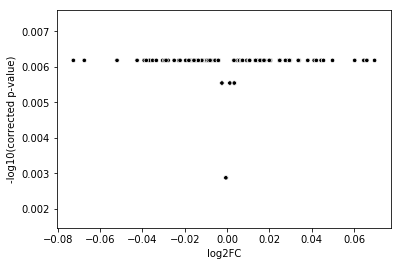

In [12]:
test.plot_volcano()